In [1]:
import numpy as np
from pangolin import d, t, Given, I, IID, vmap, recurse, scan, sample, E, P, var, std, cov, corr, jags_code, makerv
from matplotlib import pyplot as plt

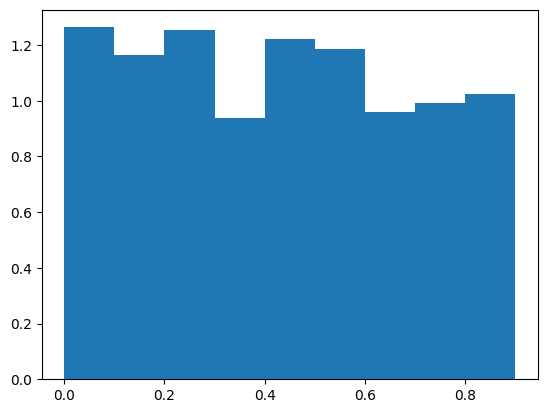

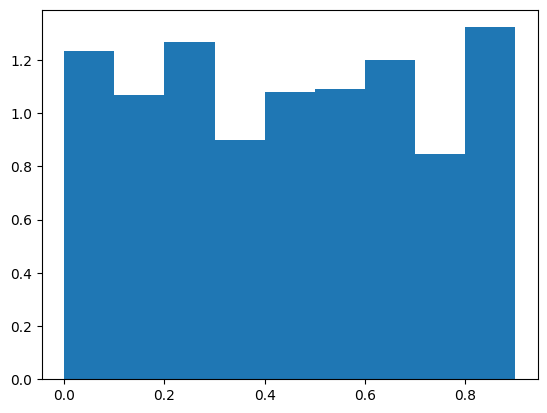

In [2]:
def simulation_rank(prior,likelihood):
    """
    1. Draw (θٰʹ,yʹ) ~ p(θ,y)
    2. Use MCMC to generate samples approximately from p(θ|yʹ)
    3. Find rank of θʹ among samples from θ
    """
    latent_vars = prior()
    observed_vars = likelihood(*latent_vars)

    # draw latents and observed variables from prior
    all_samps = sample(latent_vars + observed_vars, niter=1) # just draw one sample
    all_samps = [samps[0] for samps in all_samps] # remove dummy first dimension
    latent_samps = all_samps[:len(latent_vars)]
    observed_samps = all_samps[len(latent_vars):]

    # do inference on latents given observed variables
    evidence = [observed_var == observed_samp for (observed_var, observed_samp) in zip(observed_vars, observed_samps)]
    inference_samps = sample(latent_vars, Given(*evidence), niter=100)

    # get rank of true latents compared to sampled latents
    ranks = []
    for latent_samp, inference_samp in zip(latent_samps, inference_samps):
        ranks.append( np.mean(latent_samp < inference_samp, axis=0))

    return ranks

def SBC(prior,likelihood,nreps=1000):
    """
    Call simulation_rank several times, make a histogram
    """
    my_ranks = simulation_rank(prior,likelihood)
    ranks = [np.zeros([nreps, *r.shape]) for r in my_ranks]
    for i in range(nreps):
        my_ranks = simulation_rank(prior,likelihood)
        for r, my_r in zip(ranks, my_ranks):
            r[i] = my_r

    for r in ranks:
        plt.figure()
        plt.hist(r,np.arange(0,1,.1),density=True)
        # annoying we can't do plt.title(nameof(r))...

# Simple model with two latent variables and two observation variables, all scalar
def prior():
    u = d.norm(0,1)
    s = d.exp(1)
    return u,s

def likelihood(u,s):
    y = d.norm(u,s)
    z = d.norm(u,s)
    return y,z

SBC(prior,likelihood)

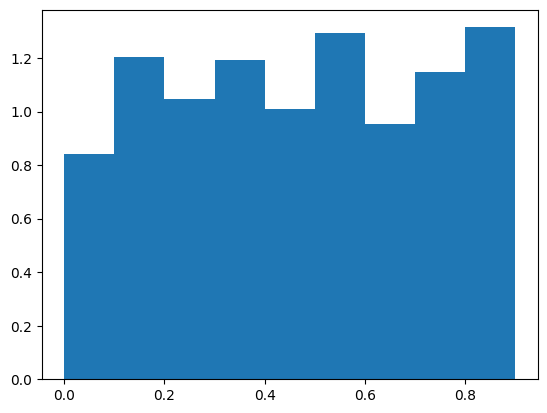

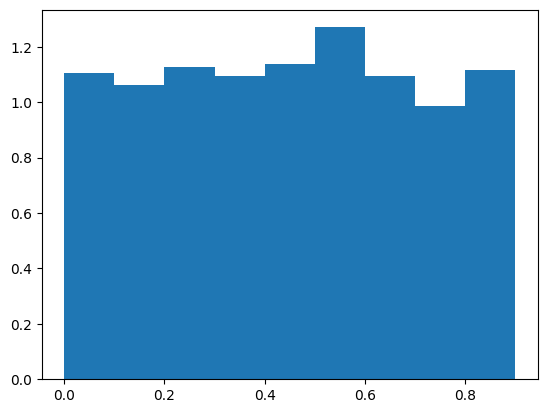

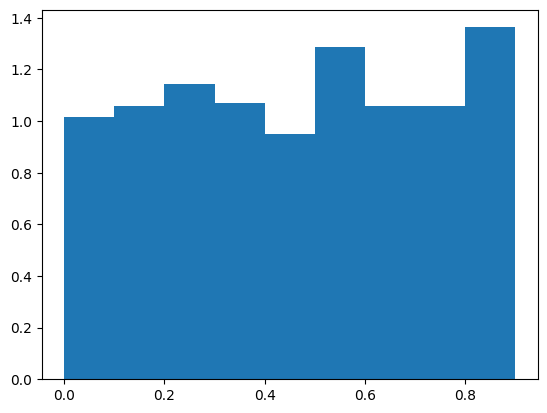

In [3]:
# proof that this works with different models

def prior():
    u1 = d.norm(0,1)
    u2 = d.norm(0,1)
    w = d.unif(0,1)
    return u1,u2,w

def likelihood(u1,u2,w):
    x1 = d.norm(u1,1)
    x2 = d.norm(x1 + w*u2, w)
    x3 = d.norm(x2 + w*u2, w)
    x4 = d.norm(x3 + w*u2, w)
    return x1, x2, x3, x4

SBC(prior,likelihood)

Alternatively, I guess you might just pass the random variables directly?

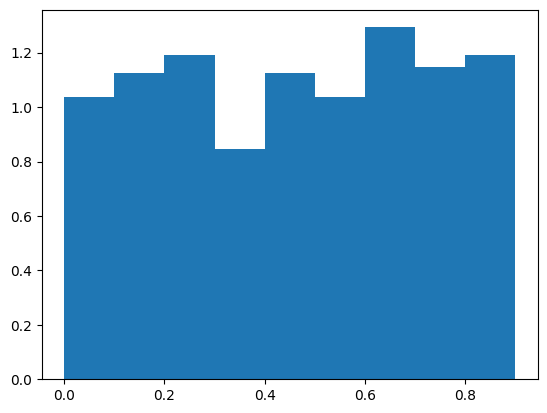

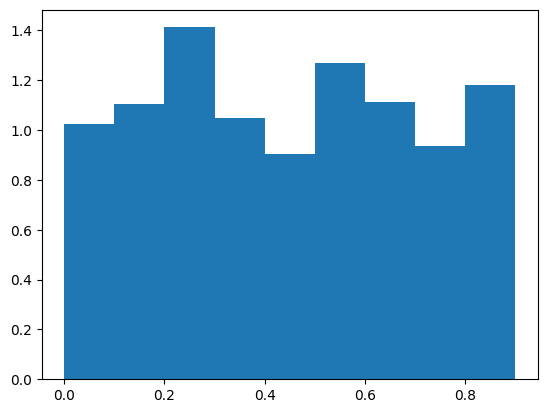

In [4]:
# Define a simple model with two latent variables and two observation variables, all scalar

def simulation_rank(latent_vars,observed_vars):
    """
    1. Draw (θٰʹ,yʹ) ~ p(θ,y)
    2. Use MCMC to generate samples approximately from p(θ|yʹ)
    3. Find rank of θʹ among samples from θ
    """
    # draw latents and observed variables from prior
    all_samps = sample(latent_vars + observed_vars, niter=1) # just draw one sample
    all_samps = [samps[0] for samps in all_samps] # remove dummy first dimension
    latent_samps = all_samps[:len(latent_vars)]
    observed_samps = all_samps[len(latent_vars):]

    # do inference on latents given observed variables
    # intentionally screw up calibration by using a small number of Gibbs iterations
    evidence = [observed_var == observed_samp for (observed_var, observed_samp) in zip(observed_vars, observed_samps)]
    inference_samps = sample(latent_vars, Given(*evidence), niter=100)

    # get rank of true latents compared to sampled latents
    ranks = []
    for latent_samp, inference_samp in zip(latent_samps, inference_samps):
        ranks.append( np.mean(latent_samp < inference_samp, axis=0))

    return ranks

def SBC(prior,likelihood,nreps=1000):
    """
    Call simulation_rank several times, make a histogram
    """
    my_ranks = simulation_rank(prior,likelihood)
    ranks = [np.zeros([nreps, *r.shape]) for r in my_ranks]
    for i in range(nreps):
        my_ranks = simulation_rank(prior,likelihood)
        for r, my_r in zip(ranks, my_ranks):
            r[i] = my_r

    for r in ranks:
        plt.figure()
        plt.hist(r,np.arange(0,1,.1),density=True)

u = d.norm(0,1)
s = d.exp(1)
y = d.norm(u,s)
z = d.norm(u,s)

latent_vars = [u,s]
observed_vars = [y,z]

SBC(latent_vars,observed_vars)